Author: Kanellakis Kosmas

Project: Clio Muse data manipulation - analysis

Professor: Aikatini Pramatari

University: Athens University of Economics and Business

Department: Management Science and Technology

Date: 12/09/2024

Import what you have to

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder



Necessary checks and variables

* make folder called outputfiles

In [14]:
if not os.path.exists('outputfiles'):
    os.makedirs('outputfiles')

output_loc = './outputfiles/'

Clean up the data and make the starting dataframes

In [5]:
def read_files():
    #read dataframes from the excel files

    try:
        if os.path.exists('dataframe1.xlsx'):
            dataframe1 = pd.read_excel('dataframe1.xlsx')
        else:
            dataframe1 = combine_review_sheets()
            
        if os.path.exists('dataframe2.xlsx'):
            dataframe2 = pd.read_excel('dataframe2.xlsx')
        else:
            dataframe2 = combine_booking_sheets()
            #add the ticket cost
            dataframe2 = add_ticket_cost(dataframe2)
            #get the Revenue
            dataframe2 = Revenue(dataframe2)
            
    except Exception as e:
        print(f"An error occurred: {e}")
    
    return dataframe1, dataframe2

def combine_review_sheets():
    #read and instantiate dataframe

    # File path to your Excel file
    file_path = 'reviews data.xlsx'  # Replace with your actual file path

    #load Excel file
    xlsx = pd.ExcelFile(file_path)

    #collect all unique column titles from each sheet
    all_columns = []

    #iterate through each sheet to collect column names
    for sheet_name in xlsx.sheet_names:
        df = pd.read_excel(file_path, sheet_name=sheet_name, header=1, nrows=0)  # Read only the second row for column names
        all_columns.extend([col for col in df.columns if col not in all_columns and not 'Unnamed' in str(col)])

    #initialize an empty DataFrame to store combined data
    combined_df = pd.DataFrame()

    #iterate through each sheet
    for sheet_name in xlsx.sheet_names:
        # Read the sheet into a DataFrame, starting from the second row for data
        df = pd.read_excel(file_path, sheet_name=sheet_name, header=1)

        # Iterate through each row to find the first entirely empty row
        for i in range(len(df)):
            if pd.isna(df.iloc[i]).all():  # Check if all elements in the row are NaN
                break
        # Keep only the data above the first entirely empty row
        df = df.iloc[:i]

        # Add a column to indicate the source sheet
        df['Source Sheet'] = sheet_name
        
        # Append this DataFrame to the combined DataFrame
        combined_df = pd.concat([combined_df, df], ignore_index=True, sort=False)

    # Reindex the combined DataFrame to include all collected columns plus the Source Sheet column
    combined_df = combined_df.reindex(columns=all_columns + ['Source Sheet'])

    #in the first column of combined_df turn "0" to "FALSE" and "1" to "TRUE"
    combined_df['Important Information'] = combined_df['Important Information'].replace({0: 'FALSE', 1: 'TRUE'})

    #rename the dataframe to dataframe1
    dataframe1 = combined_df
    
    #split recommended['Name of Product Reviewed'] to 2 columns seperated by '|'
    dataframe1[['product_code', 'product_review']] = dataframe1['Name of Product Reviewed'].str.split('|', expand=True)
    
    #drop the column Name of Product Reviewed
    dataframe1.drop(columns=['Name of Product Reviewed'], inplace=True)
    
    #drop the rows where product_code column is na
    dataframe1.dropna(subset=['product_code'], inplace=True)
    
    #drop the rows where product_code do not have in them "STL,TO,AU,TL"
    dataframe1 = dataframe1[dataframe1['product_code'].str.startswith(('STL', 'TO', 'AU', 'TL'))]
    
    #for the column "Overall Experience" for each row keep only the number
    dataframe1.loc[:, 'Overall Experience'] = dataframe1['Overall Experience'].str.extract('(\d+)', expand=False)
    
    #remove the spaces from the product_code column
    dataframe1['product_code'] = dataframe1['product_code'].str.strip()
    
    dataframe1.to_excel('dataframe1.xlsx', index = False)
    

    
    return dataframe1

def combine_booking_sheets():
    # File path to your Excel file
    file_path = 'Booking Stats.xlsx'  # Replace with your actual file path

    # List of month names to include
    month_names = [
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ]

    # Load Excel file
    xlsx = pd.ExcelFile(file_path)

    # Initialize an empty DataFrame to store combined data
    combined_df = pd.DataFrame()

    # Iterate through each sheet
    for sheet_name in xlsx.sheet_names:
        if sheet_name in month_names:  # Only combine if the sheet is a month
            # Read the sheet into a DataFrame, using the first row as the header
            df = pd.read_excel(file_path, sheet_name=sheet_name)
            
            # Add a column to indicate the source sheet
            df['Source Sheet'] = sheet_name
            
            # Append this DataFrame to the combined DataFrame
            combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    # Rename the combined DataFrame to dataframe2
    dataframe2 = combined_df
    
    # sort dataframe2 by id
    dataframe2 = dataframe2.sort_values(by='id')

    dataframe2 = manipulate_dataframe2(dataframe2)
        
    return dataframe2

def manipulate_dataframe2(dataframe2):
    # Language codes mapping based on the provided information
    language_codes = {
        'Greek': 'GR', 'English': 'EN', 'Chinese': 'CH', 'Italian': 'IT',
        'German': 'DE', 'French': 'FR', 'Russian': 'RU', 'Spanish': 'ES',
        'Romanian': 'RO', 'Serbian': 'SR', 'Turkish': 'TR', 'Hebrew': 'HE',
        'Czech': 'CS', 'Hungarian': 'HU', 'Polish': 'PL', 'Bosnian': 'BS',
        'Albanian': 'SQ', 'Irish': 'GA', 'Norwegian': 'NO', 'Portuguese': 'PT',
        'Korean': 'KO', 'Japanese': 'JA'
    }

    # Function to map full language name to language code
    def map_language_to_code(language):
        return language_codes.get(language, None)

    # Apply the function to the 'Language' column to create a new 'Language Code' column
    # Replace 'LanguageColumnName' with the actual name of the column in dataframe2 that contains language names
    dataframe2['Language Code'] = dataframe2['language'].apply(map_language_to_code)

    return dataframe2

def add_ticket_cost(dataframe2):
    
    # Load the "ticket cost" sheet into a DataFrame
    ticket_cost_df = pd.read_excel('Booking Stats.xlsx', sheet_name='Ticket Cost')
    
    # Set the product code as the index for easier access
    ticket_cost_df.set_index('Product Code', inplace=True)
        
    # Drop the rows where net_price column is na
    dataframe2.dropna(subset=['net_price'], inplace=True)
    
    # Concatenate the product_code and Language Code
    dataframe2['Full Product Code'] = dataframe2['product_code'] + dataframe2['Language Code']
    
    # Iterate over each row in dataframe2
    for index, row in dataframe2.iterrows():
        # Get the full product code for the current row
        full_product_code = row['Full Product Code']
        # Get the month for the current row, assuming the 'month' column format is 'Month YYYY'
        month = row['month'].split()[0]  # Take only the first part, which is the month name
        
        # Find the price in the ticket cost dataframe
        if full_product_code in ticket_cost_df.index:
            # Extract the price for the corresponding month
            price = ticket_cost_df.at[full_product_code, month]
            # Check if the price is a Series or a single value
            if isinstance(price, pd.Series):
                price = price.iloc[0]  # Take the first element of the Series
            elif isinstance(price, str):
                # Clean up the price to be a float (remove '€' and convert to float)
                price = float(price.replace('€', ''))
        else:
            # If the product code is not found, set the price to None or a default value
            price = 0
        
        dataframe2.at[index, 'Ticket Price'] = price
    
    #drop the 'Full Product Code' column
    dataframe2.drop(columns=['Full Product Code'], inplace=True)
    
    #fill the NaN values with 0
    dataframe2['Ticket Price'].fillna(0, inplace=True)
        
    return dataframe2

def Revenue(dataframe2):
        
    #calculate the profit
    dataframe2['Revenue'] = dataframe2['retail_price'] - dataframe2['Ticket Price']
    
    dataframe2.to_excel('dataframe2.xlsx', index = False)
    
    return dataframe2

#Create the dataframes
dataframe1, dataframe2 = read_files()

Find the revenues of the tours

In [10]:
def revenue_per_tour():
    # Now group by 'product_code' and calculate the sum and avg of 'Revenue' and number of travellers
    Revenue = dataframe2.groupby('product_code').agg({'num_of_travellers': 'sum', 'Revenue': ['sum']}).reset_index()
    
    # Calculate the average profit per tour
    Revenue['Average Revenue'] = Revenue['Revenue']['sum'] / Revenue['num_of_travellers']['sum']
    
    # Rename the columns for clarity
    Revenue.columns = ['product_code', 'Total Travellers', 'Total Revenue', 'Average Revenue']
    
    # Swap the places of the last 2 columns
    Revenue = Revenue[['product_code', 'Total Travellers', 'Average Revenue', 'Total Revenue']]
    
    # Save the grouped data to a new Excel file
    Revenue.to_excel(output_loc + 'grouped_revenue.xlsx', index=False)
    

revenue_per_tour()

Make the clusters and get their data

In [20]:
def testk_means():
    copy = dataframe2.copy()
    
    # Encode the "tours" column with label encoder
    le_product_country = LabelEncoder()
    le_language = LabelEncoder()
    copy['product_country'] = le_product_country.fit_transform(copy['product_country'])
    copy['num_of_travellers'] = le_language.fit_transform(copy['num_of_travellers'])
    
    # Convert month names to numerical values
    month_mapping = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    copy['Source Sheet'] = copy['Source Sheet'].map(month_mapping)
    
    # Select features for clustering
    features = ['num_of_travellers', 'Revenue', 'Source Sheet', 'product_country']
    X = copy[features]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Determine the optimal number of clusters using the Elbow Method
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
    
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
    # Calculate the silhouette score for k=4 (or any other number you choose)
    k = 3
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    print(f'Silhouette Score for k={k}: {silhouette_avg}')
    
    # Add cluster labels to the dataframe
    copy['cluster'] = kmeans.labels_
    
    # Return the product country and language to their original values
    copy['product_country'] = le_product_country.inverse_transform(copy['product_country'])
    copy['num_of_travellers'] = le_language.inverse_transform(copy['num_of_travellers'])
    
    # Reverse the mapping for the month column
    month_mapping = {v: k for k, v in month_mapping.items()}
    copy['Source Sheet'] = copy['Source Sheet'].map(month_mapping)
    
    #sort the dataframe by id
    copy = copy.sort_values(by='id')
    
    # Save the clustered data to an Excel file
    copy.to_excel(output_loc + 'clustered_products.xlsx', index=False)
    
#add the cluster to dataframe 2 xslx
def add_cluster():
    
    #kmeans check if exists
    if not os.path.exists(output_loc + 'clustered_products.xlsx'):
        testk_means()
    
    #load the clustered_products.xlsx file
    clustered = pd.read_excel(output_loc + 'clustered_products.xlsx')
    
    #load the dataframe2.xlsx file
    dataframe2 = pd.read_excel('dataframe2.xlsx')
    
    #add the cluster column to dataframe2
    dataframe2['cluster'] = clustered['cluster']
    
    #save the results to an excel file
    clustered.to_excel('dataframe2.xlsx', index=False)
    
    #drop all the column but the cluster and product_code
    clustered = clustered[['cluster', 'product_code']]
    
    #return the dataframe2
    return dataframe2

def cluster_data():
    #from dataframe2 make a copy of it
    df2_copy = dataframe2.copy()
    
    #totals
    total_travellers = df2_copy['num_of_travellers'].sum()
    total_revenue = df2_copy['Revenue'].sum()
    total_tours = (df2_copy['tours'].str.count(',') + 1).sum()
    
    #group by cluster and calculate the percentages of num_of_travellers from the total travellers
    cluster_travellers = df2_copy.groupby('cluster')['num_of_travellers'].agg(['sum']).reset_index()
    
    #group by cluster and calculate the sum
    cluster_revenue = df2_copy.groupby('cluster')['Revenue'].agg(['sum']).reset_index()
    
    #create a new column that counts the number of tours for each row
    df2_copy['tours_count'] = df2_copy['tours'].str.count(',') + 1
    
    #group by cluster and calculate the sum of tours
    cluster_tours = df2_copy.groupby('cluster')['tours_count'].agg(['sum']).reset_index()
    
    #divide all the values with the total values and multiply them by 100
    cluster_travellers['sum'] = cluster_travellers['sum'] / total_travellers * 100
    cluster_revenue['sum'] = cluster_revenue['sum'] / total_revenue * 100
    cluster_tours['sum'] = cluster_tours['sum'] / total_tours * 100
    
    
    #final
    cluster_final_revenue = cluster_revenue
    cluster_final_travellers = cluster_travellers
    cluster_final_tours = cluster_tours
    
    
    
    #save everything on an excel file on different sheets
    with pd.ExcelWriter(output_loc +'cluster_data.xlsx') as writer:
        cluster_final_travellers.to_excel(writer, sheet_name='cluster_final_travellers', index=False)
        cluster_final_revenue.to_excel(writer, sheet_name='cluster_final_revenue', index=False)
        cluster_final_tours.to_excel(writer, sheet_name='cluster_final_tours', index=False)
        
dataframe2 = add_cluster()

#cluster manipulation
cluster_data()

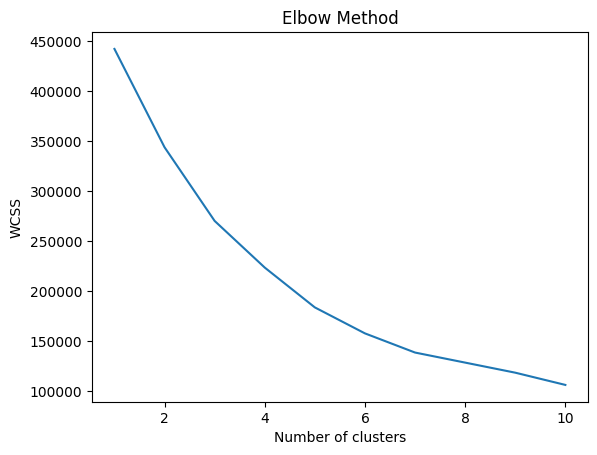

Silhouette Score for k=3: 0.3664790503379209


Get the bubble chart

In [22]:
def bubble_chart_places():
    #create a copy of the dataframe2 to operate upon
    bubble_chart = dataframe2.copy()
    
    #group by cluster and product_country and calculate the sum of num_of_travellers
    bubble_chart = bubble_chart.groupby(['cluster', 'product_country'])['num_of_travellers'].sum().reset_index()
    
    #sort by num_of_travellers in descending order
    bubble_chart = bubble_chart.sort_values(by=['num_of_travellers'], ascending=False)
    
    #save the results to an excel file
    bubble_chart.to_excel(output_loc + 'bubble_chart.xlsx', index=False)
    
    #make a bubble chart
    fig, ax = plt.subplots()
    for cluster in bubble_chart['cluster'].unique():
        data = bubble_chart[bubble_chart['cluster'] == cluster]
        ax.scatter(data['product_country'], data['cluster'], s=data['num_of_travellers'], label=f'Cluster {cluster}', alpha=0.5)
    fig.set_size_inches(18.5, 10.5)
    ax.set_xlabel('Country')
    ax.set_ylabel('Cluster')
    ax.set_title('Bubble Chart of Travellers by Country and Cluster')
    # make a border around the chart
    
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(output_loc + 'bubble_chart.png')
    plt.show()
    
bubble_chart_places()

Normalization of stars for for total number of tourists

In [11]:
def recommended_stories():
    # For each product code group by the 'Overall Experience' column and count how many times each rating appears while keeping the product code as a column
    recommended = dataframe1.groupby(['product_code', 'Overall Experience']).size().unstack(fill_value=0).reset_index()
    
    #clear all the spaces from recommended the product_code column
    recommended['product_code'] = recommended['product_code'].str.strip()
    
    recommended.to_excel(output_loc + 'recommended_by_stars.xlsx', index=False)
    
    #Load the grouped_profit.xslx file
    grouped_profit = pd.read_excel(output_loc + 'grouped_profit.xlsx')
    
    #merge the grouped_profit with the recommended dataframe
    grouped_profit = pd.merge(recommended, grouped_profit, on='product_code', how='left')
            
    #save the grouped_profit to an excel file
    grouped_profit.to_excel(output_loc + 'recommended_by_stars&profit.xlsx', index=False)
    
    stars()
    
def stars():
    #load the recommended_by_stars&profit.xlsx file
    recommended = pd.read_excel(output_loc + 'recommended_by_stars&profit.xlsx')
    
    #calculate the sum of the 2nd, 3rd, 4th, 5th and 6th columns of each row
    recommended['sum'] = recommended.iloc[:, 1:6].sum(axis=1)

    #divide the sum column with the 'Total Travellers' column
    recommended['percentage'] = recommended['sum'] / recommended['Total Travellers']
    
    #for each row and for the 2nd, 3rd, 4th, 5th and 6th columns multiply by the percentage column
    recommended.iloc[:, 1:6] = recommended.iloc[:, 1:6] * recommended['percentage'].values[:, None]
    
    #multiply the 2nd, 3rd, 4th, 5th and 6th columns by 1 2 3 4 5 respectively
    recommended.iloc[:, 1:6] = recommended.iloc[:, 1:6].multiply([1, 2, 3, 4, 5], axis=1)
    
    #calculate the sum of the 2nd, 3rd, 4th, 5th and 6th columns of each row
    recommended['sum'] = recommended.iloc[:, 1:6].sum(axis=1)
    
    #export the results to an excel file
    recommended.to_excel(output_loc + 'recommended_by_stars&profit&percentage.xlsx', index=False)

recommended_stories()


Number of tours per packet

In [ ]:
def optimum_number_of_stories():
    #create a copy of the dataframe2 to operate upon
    dataframe2_copy = dataframe2.copy()
    
    dataframe2_copy['tours'] = dataframe2_copy['tours'].str.count(',') + 1
    
    #to excel
    dataframe2_copy.to_excel(output_loc + 'tours_to_numbers.xlsx', index=False)
    
    #turn the cluster column to int
    dataframe2_copy['cluster'] = dataframe2_copy['cluster'].astype(int)
    
    #group by cluster and tours and count the instances
    optimum_number_of_stories = dataframe2_copy.groupby(['cluster', 'tours']).size().reset_index()
    
    optimum_number_of_stories.to_excel(output_loc + 'optimum_number_of_stories.xlsx', index=False)
    
    #group by cluster and tours and calculate the sum of Revenue
    optimum_number_of_stories_revenue = dataframe2_copy.groupby(['cluster', 'tours', 'product_country'])['Revenue'].sum().reset_index()
    optimum_number_of_stories_revenue.to_excel(output_loc + 'optimum_number_of_stories_revenue.xlsx', index=False)

optimum_number_of_stories()

4th slide: 

Make a copy of recommended_by_stars&profit&percentage to a new file. With VLOOKUP find the clusters.

Grade the normalized stars from 1 to 100 with 100 being the best and 1 the lowest.

Grade the revenue the same way after nomralizing it first.

Lastly add the 2 grades of stars and revenues and you get the grading for the clusters.

Formulas:
* Normalization:
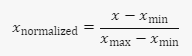

* Grading:
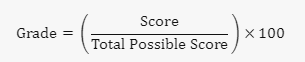

5th slide:

1. Travellers: Sum of cluster's number of tourists / total tourists
2. Revenou: Sum of cluster's total revenue / total revenue
3. Tours: Number of cluster's tours / total tours

6th slide:

Sum of cluster's total stars / cluster's total number of tourists